Import the data from database

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# connect to sqlite3 database

# Replace with your database file path in Google Drive
db_path = '/content/drive/MyDrive/House Loan Analytics/my_database.db'

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

df_encoded = pd.read_sql("SELECT * FROM Interest_Rate_Features", conn)
# Example query (replace with your actual query)
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)

conn.close()

[('raw_data',), ('Loan_Approval',), ('Interest_Rate_Features',)]


Model

In [15]:
# Load dataset
df = df_encoded.copy()

# Define target and predictors
target = 'interest_rate'
predictors = df.columns[df.columns != target]

X = df[predictors]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# XGBoost Regressor Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.3, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Performance:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"R^2 Score: {r2_score(y_true, y_pred)}\n")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor")


Linear Regression Performance:
MAE: 0.8811087910426461
MSE: 1.7514630633691048
RMSE: 1.3234285259767922
R^2 Score: 0.29158120548395017

XGBoost Regressor Performance:
MAE: 0.7372681813053902
MSE: 1.080985630789137
RMSE: 1.0397045882312614
R^2 Score: 0.5627709464910201



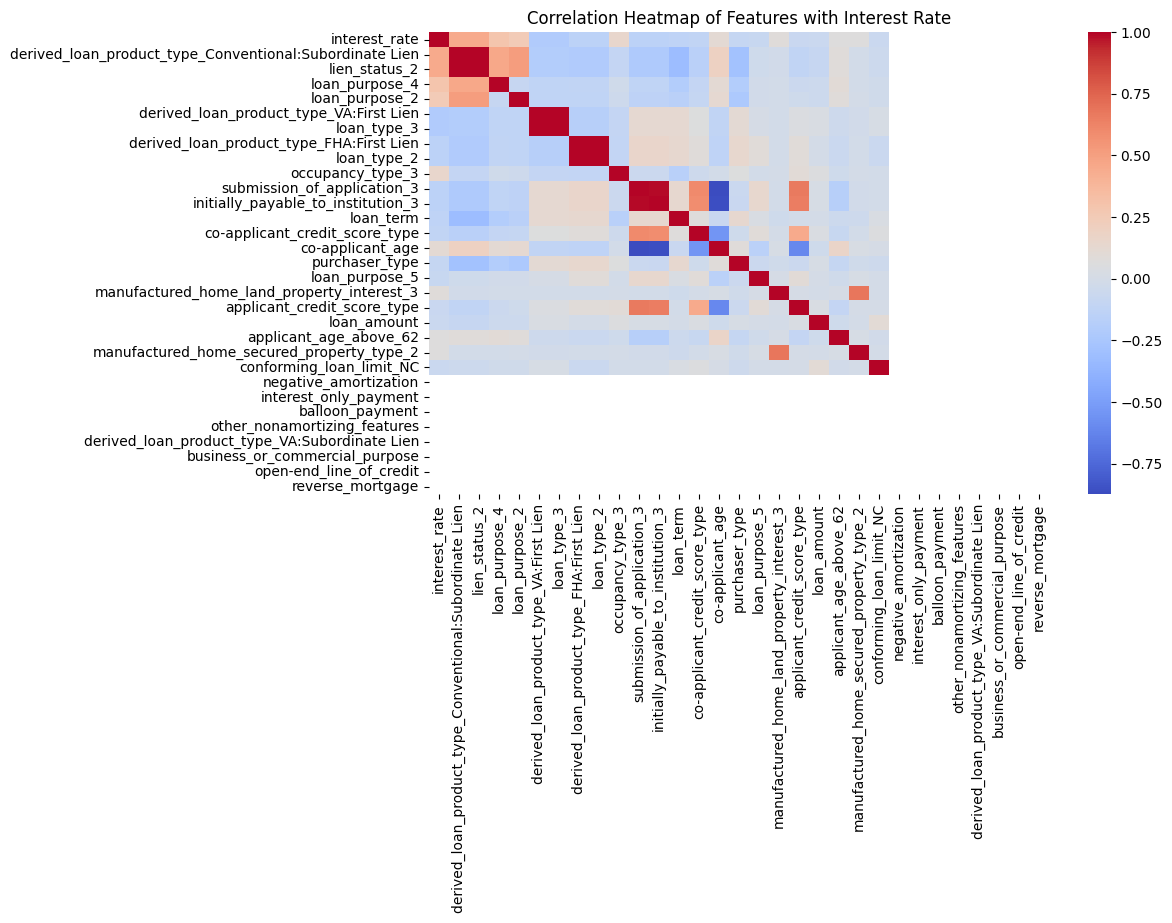

In [8]:
# Compute correlation with interest_rate
correlation = df_encoded.corr()['interest_rate'].abs().sort_values(ascending=False)

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded[correlation.index].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Features with Interest Rate")
plt.show()

# Display highly correlated features
correlation[1:15]  # Exclude interest_rate itself

# Drop low-correlation columns
low_corr_features = correlation[correlation < 0.05].index
df_reduced = df_encoded.drop(columns=low_corr_features)
